In [1]:
import sys

from models.agent import Agent
from models.model_transformers import Model_args
import pickle
import torch


dataset = 'dataset\one_ball.pkl'

with open(dataset, 'rb') as f:
    dataset = pickle.load(f)
    
states, states_white, labels = dataset['states'], dataset['states_white'], dataset['label']

states_white = [ s.unsqueeze(0) for s in states_white]
states = [ s.unsqueeze(0) for s in states]
labels = [ s.unsqueeze(0) for s in labels]


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 128

states = torch.concatenate(states).to(device)
states_white = torch.concatenate(states_white).to(device)
labels = torch.concatenate(labels).to(device)


model_args = Model_args(
    embed_dim = 1024,
    num_heads = 8,
    ff_dim    = 4*1024,
    num_layers =1,
    dropout  = 0,
    mlp_dim=1024,
)


agent = Agent(action_dim=2, model_args=model_args).to(device)



print("WARNING - APLICANDO NORMALIZAÇÃO NO DATASET")
#states[:,:,0] = states[:,:,0] / 800
#states[:,:,1] = states[:,:,1] / 400
#states_white[:,0] = states_white[:,0] / 800
#states_white[:,1] = states_white[:,1] / 400
# -------------------------
epochs = 10
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(agent.parameters(), lr=0.001)


split_idx = 6000
test_states = states[split_idx:]
test_states_white = states_white[split_idx:]
test_labels = labels[split_idx:]
train_states = states[:split_idx]
train_states_white = states_white[:split_idx]
train_labels = labels[:split_idx]

WARNING - APLICANDO NORMALIZAÇÃO NO DATASET


In [2]:
    
def evaluate(agent):
    agent.eval()  # Coloca o modelo em modo de avaliação

    with torch.no_grad():
        output = agent.actor_mean(test_states, test_states_white)
        mse = torch.nn.functional.mse_loss(output[:,0], test_labels[:,0])

    return mse.item()


In [9]:
from tqdm import tqdm
losses = []
losses_test = []

losses_test.append(evaluate(agent))
print(f" Loss Test: {losses_test[-1]}")


for epc in range(epochs):
    agent.train()
    for i in tqdm(range(0, len(states), batch_size)):
        batch_states = states[i:i+batch_size]
        batch_states_white = states_white[i:i+batch_size]
        batch_label = labels[i:i+batch_size]
        
        output = agent.actor_mean(batch_states, batch_states_white)
        output = output[:,0]
        batch_label = batch_label[:,0]
        loss_value = loss(output, batch_label)
        
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        losses.append(loss_value.item())
    
    losses_test.append(evaluate(agent))
    print(f"Epoch {epc} - Loss: {losses[-1]} - Loss Test: {losses_test[-1]}")

 Loss Test: 0.10617955029010773


  0%|          | 0/55 [00:00<?, ?it/s]

100%|██████████| 55/55 [00:02<00:00, 23.66it/s]


Epoch 0 - Loss: 0.07712698727846146 - Loss Test: 0.16204676032066345


100%|██████████| 55/55 [00:02<00:00, 24.49it/s]


Epoch 1 - Loss: 0.1255646049976349 - Loss Test: 0.08414249867200851


100%|██████████| 55/55 [00:02<00:00, 25.50it/s]


Epoch 2 - Loss: 0.35482585430145264 - Loss Test: 0.41618970036506653


100%|██████████| 55/55 [00:02<00:00, 25.18it/s]


Epoch 3 - Loss: 0.08650097250938416 - Loss Test: 0.1364562064409256


100%|██████████| 55/55 [00:02<00:00, 26.52it/s]


Epoch 4 - Loss: 0.3192104399204254 - Loss Test: 0.1522943526506424


100%|██████████| 55/55 [00:02<00:00, 24.15it/s]


Epoch 5 - Loss: 0.029294831678271294 - Loss Test: 0.13906657695770264


100%|██████████| 55/55 [00:02<00:00, 25.86it/s]


Epoch 6 - Loss: 0.040183503180742264 - Loss Test: 0.12437700480222702


100%|██████████| 55/55 [00:01<00:00, 28.67it/s]


Epoch 7 - Loss: 0.026570064947009087 - Loss Test: 0.13508105278015137


100%|██████████| 55/55 [00:01<00:00, 27.86it/s]


Epoch 8 - Loss: 0.37809908390045166 - Loss Test: 0.17740914225578308


100%|██████████| 55/55 [00:01<00:00, 28.12it/s]

Epoch 9 - Loss: 0.03994094952940941 - Loss Test: 0.16418500244617462


In [4]:
x = states[0].unsqueeze(0)
bola_branca = states_white[0].unsqueeze(0)
b = x.shape[0]
        
t_concat = torch.zeros(b,2, device=bola_branca.device)
t_concat[:,0] = 1
t_concat[:,1] = -1

bola_branca = torch.concat( (bola_branca , t_concat), dim=-1).unsqueeze(1)
x = torch.concat((bola_branca,x),dim=1)

# [b, 16, 4]
x = x.view(b,-1)
x.shape

torch.Size([1, 64])

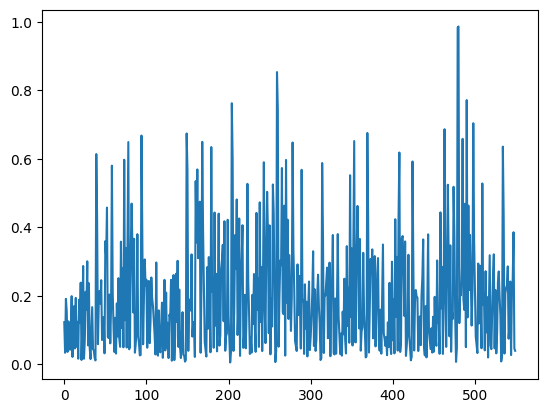

In [10]:
import matplotlib.pyplot as plt 

plt.plot(losses)

In [11]:
# save model
torch.save(agent.state_dict(), 'agent_big.pth')

In [14]:
from game import GAME
env = GAME(draw=True)


In [40]:
# load
iteration = r"C:\CEIA\RL\8pool-with-reinforcement-learning\runs\__PPO__1__1734357635\PPO_model_iteration_39"
agent2 = Agent(action_dim=2, model_args=model_args).to(device)
agent2.load_state_dict(torch.load(iteration))

C:\Users\fazzi\AppData\Local\Temp\ipykernel_83720\2084076435.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent2.load_state_dict(torch.load(iteration))


<All keys matched successfully>

In [45]:
from curriculum.reset import reset_random_one_ball
import matplotlib.pyplot as plt
import pickle

from tqdm import tqdm

# load weights



state, state_bola_branca = reset_random_one_ball(env=env)

action  = agent2.actor_mean( state.unsqueeze(0), state_bola_branca.unsqueeze(0) )

o = env.step(action[0].detach().cpu().numpy().tolist())


In [38]:
o[-3]

{'colisoes': [(<utils.Ball.Ball at 0x1edb342e550>,
   <utils.Ball.Ball at 0x1edb3460dd0>)],
 'bolas_caidas': [],
 'state': [<utils.Ball.Ball at 0x1edb342cd50>,
 'perdeu': False,
 'ganhou': False,
 'penalizado': False,
 'joga_novamente': False,
 'bolas_jogador': [2],
 'bolas_adversario': [1],
 'winner': None}